# Assignment 2 - Solutions (V2)

This version applies the annualization factor directly to the mean returns and the covariance matrix of returns, rather than the daily returns time series.

In Part 1, the portfolio $\omega_{a,b}$ has a risk-return representation that is too far from the other portfolios, so we omit this from all plots.

In the TEV analysis, when performing the regression step for the betas, we need to annualize the daily returns (or express the risk-free rate in daily terms).

In Part 2, this means that the estimated covariance matrix $\hat{\Sigma} = B \Sigma_F B^\top + \Sigma_\epsilon$ must be annualized to match the empirical covariance matrix obtained in Part 0 (used in Part 1). The coefficient $A$ of the $k$-factor model must also be the mean of the daily returns (not the annualized daily returns).

In [56]:
# Load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import datetime
import time

# Load scikit-learn library (linear regression and PCA)
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Part 0: Data Pre-Processing

In [57]:
# Set starting and ending dates
start = datetime.datetime(2022,1,4)
end = datetime.datetime(2023,12,22)

# Count number of calendar days between starting and ending dates (for annualization)
n_cal_days = end - start
n_cal_days = n_cal_days.days

In [58]:
# Read data (close prices)
prices = pd.read_csv('ASX200ClosePrices.csv', index_col = 0).dropna()
# prices

In [59]:
# Annualization factor
ann_factor = 1 / ((n_cal_days / 365) / len(prices))

# Calculate percentage returns
ret_all = prices / prices.shift(1) - 1

# Remove rows with NaN
ret_all = ret_all.dropna()

# # Annualize the observed daily returns
# ret_all = ann_factor * ret_all

# Stock returns only
ret_stocks_all = ret_all.iloc[:, 0:(len(ret_all.columns)-1)]
sym_stocks_all = ret_stocks_all.columns

# Index returns
ret_index = ret_all['^AXJO']

In [60]:
# Estimate of mean returns of stocks (complete) [ANNUALIZED]
mean_ret_stocks_all = ann_factor * ret_stocks_all.mean(axis = 0)

# Estimated covariance matrix of returns of stocks [ANNUALIZED]
cov_ret_stocks_all = ann_factor * ret_stocks_all.cov()
inv_cov_ret_stocks_all = np.linalg.inv(cov_ret_stocks_all)

# Standard deviation of returns of stocks
sigma_ret_stocks_all = pd.Series(np.diag(cov_ret_stocks_all), index = cov_ret_stocks_all.columns) ** 0.5

# Estimated mean return of index [ANNUALIZED]
mean_ret_index = ann_factor * ret_index.mean(axis = 0)

# Estimated variance of returns of index [ANNUALIZED]
var_ret_index = ann_factor * ret_index.var()
sigma_ret_index = np.sqrt(var_ret_index)

In [61]:
# Risk-free rate (annualized; can be verified later to satisfy r0 < b / a)
r0 = 0.10

# Target expected return (annualized)
target_ret = 0.50

# Number of stocks to consider (this affects the choice of r0)
n_stocks = 15

In [62]:
## - Sort stocks by Sharpe ratio
SR_stocks = (mean_ret_stocks_all - r0) / sigma_ret_stocks_all
SR_stocks_sorted = SR_stocks.sort_values(ascending = False)

SR_stocks_sorted[0:n_stocks]

NEU.AX    1.693122
AZS.AX    1.526059
EMR.AX    1.239481
SMR.AX    1.076119
WHC.AX    1.065210
NHC.AX    0.876673
BGL.AX    0.754688
SVW.AX    0.738161
WOR.AX    0.633920
YAL.AX    0.622428
BOE.AX    0.620713
ORG.AX    0.515365
VNT.AX    0.508062
AGL.AX    0.493500
PME.AX    0.477203
dtype: float64

In [63]:
# Historical returns of the top stocks
ret_stocks = ret_all[SR_stocks_sorted.head(n_stocks).index]

# Mean returns of the top stocks [ANNUALIZED]
mean_ret_stocks = ann_factor * ret_stocks.mean(axis = 0)

# Covariance matrix of returns of top stocks [ANNUALIZED]
cov_ret_stocks = ann_factor * ret_stocks.cov()
inv_cov_ret_stocks = np.linalg.inv(cov_ret_stocks)

# Standard deviation of returns of top stocks
sigma_ret_stocks = pd.Series(np.diag(cov_ret_stocks), index = cov_ret_stocks.columns) ** 0.5

# Part 1: Mean-Variance Analysis

In [64]:
## - Important quantities for Markowitz mean-variance analysis
vec1 = np.linspace(1, 1, len(mean_ret_stocks))
mv_a = vec1.T @ inv_cov_ret_stocks @ vec1
mv_b = vec1.T @ inv_cov_ret_stocks @ mean_ret_stocks

In [65]:
mv_b / mv_a, mv_a, mv_b

(0.3231252596402444, 42.18305299004023, 13.630409949824937)

In [66]:
## - Composition and characteristics of minimum-variance, omega, and tangent portfolios

# (Global) minimum-variance portfolio
phi_minvar = (1 / mv_a) * inv_cov_ret_stocks @ vec1 
mean_minvar = mv_b / mv_a
sigma_minvar = 1 / (mv_a ** 0.5)

# Self-financing portfolio \omega_{a,b}
mean_omega = np.sqrt((mean_ret_stocks - (mv_b / mv_a) * vec1).T @ inv_cov_ret_stocks 
                  @ (mean_ret_stocks - (mv_b / mv_a) * vec1))
omega = inv_cov_ret_stocks @ (mean_ret_stocks - (mv_b / mv_a) * vec1) / mean_omega
sigma_omega = 1

# Tangent portfolio
phi_tangent = (1 / (mv_b - r0 * mv_a)) * inv_cov_ret_stocks @ (mean_ret_stocks - r0 * vec1)
mean_tangent = r0 + (1 / (mv_b - r0 * mv_a)) * (mean_ret_stocks - r0 * vec1).T \
            @ inv_cov_ret_stocks @ (mean_ret_stocks - r0 * vec1)
sigma_tangent = np.sqrt((1 / (mv_b - r0 * mv_a) ** 2) * (mean_ret_stocks - r0 * vec1).T \
            @ inv_cov_ret_stocks @ (mean_ret_stocks - r0 * vec1))

## Q1

In [67]:
phi_minvar_df = pd.DataFrame(data = phi_minvar, index = SR_stocks_sorted.head(n_stocks).index)

print('Composition of minimum-variance portfolio: ')
print(phi_minvar_df)

print('Mean return of minimum-variance portfolio: ', mean_minvar)
print('Standard deviation of return of minimum-variance portfolio: ', sigma_minvar)

Composition of minimum-variance portfolio: 
               0
NEU.AX  0.034562
AZS.AX -0.000095
EMR.AX  0.114249
SMR.AX  0.017266
WHC.AX -0.051497
NHC.AX  0.044998
BGL.AX -0.019951
SVW.AX  0.269185
WOR.AX  0.084874
YAL.AX  0.043677
BOE.AX -0.058670
ORG.AX  0.080459
VNT.AX  0.175678
AGL.AX  0.194217
PME.AX  0.071048
Mean return of minimum-variance portfolio:  0.3231252596402444
Standard deviation of return of minimum-variance portfolio:  0.15396818693774153


## Q2

In [68]:
omega_df = pd.DataFrame(data = omega, index = SR_stocks_sorted.head(n_stocks).index)

print('Composition of omega portfolio: ')
print(omega_df)

print('Mean return of omega portfolio: ', mean_omega)
print('Standard deviation of return of omega portfolio: ', sigma_omega)

Composition of omega portfolio: 
               0
NEU.AX  1.006505
AZS.AX  0.600754
EMR.AX  0.816851
SMR.AX  0.366626
WHC.AX  0.668482
NHC.AX -0.170766
BGL.AX  0.093979
SVW.AX -0.605709
WOR.AX -0.947120
YAL.AX -0.200395
BOE.AX -0.004218
ORG.AX  0.041915
VNT.AX -0.901385
AGL.AX -0.459722
PME.AX -0.305796
Mean return of omega portfolio:  2.412511666087145
Standard deviation of return of omega portfolio:  1


## Q3

In [69]:
phi_tangent_df = pd.DataFrame(data = phi_tangent, index = SR_stocks_sorted.head(n_stocks).index)

print('Composition of tangent portfolio: ')
print(phi_tangent_df)

print('Mean return of tangent portfolio: ', mean_tangent)
print('Standard deviation of return of tangent portfolio: ', sigma_tangent)

Composition of tangent portfolio: 
               0
NEU.AX  0.292549
AZS.AX  0.153890
EMR.AX  0.323624
SMR.AX  0.111240
WHC.AX  0.119848
NHC.AX  0.001227
BGL.AX  0.004138
SVW.AX  0.113930
WOR.AX -0.157892
YAL.AX -0.007689
BOE.AX -0.059751
ORG.AX  0.091203
VNT.AX -0.055365
AGL.AX  0.076381
PME.AX -0.007334
Mean return of tangent portfolio:  0.9415005067215588
Standard deviation of return of tangent portfolio:  0.2990086947954148


In [70]:
## - Composition and characteristics of optimal portfolios with target expected return

# Mean-variance optimal with no risk-free asset
phi_mv_nrf = phi_minvar + ((target_ret - mean_minvar) / mean_omega) * omega
mean_mv_nrf = phi_mv_nrf @ mean_ret_stocks
sigma_mv_nrf = np.sqrt(sigma_minvar ** 2 + ((mean_mv_nrf - mean_minvar) / mean_omega) ** 2)

# Mean-variance optimal with risk-free asset
sep_thm_coef = (target_ret - r0) / (mean_tangent - r0)
phi_mv_rf = np.append(1 - sep_thm_coef, sep_thm_coef * phi_tangent)
mean_mv_rf = sep_thm_coef * mean_tangent + (1 - sep_thm_coef) * r0   # should be mean_target, but just to check
sigma_mv_rf = abs(sep_thm_coef) * sigma_tangent

# Q4

In [71]:
phi_mv_nrf_df = pd.DataFrame(data = phi_mv_nrf, index = SR_stocks_sorted.head(n_stocks).index)

print('Composition of MF NRF portfolio: ')
print(phi_mv_nrf_df)

print('Mean return of MV NRF portfolio: ', mean_mv_nrf)
print('Standard deviation of return of MV NRF portfolio: ', sigma_mv_nrf)

Composition of MF NRF portfolio: 
               0
NEU.AX  0.108354
AZS.AX  0.043950
EMR.AX  0.174137
SMR.AX  0.044145
WHC.AX -0.002487
NHC.AX  0.032478
BGL.AX -0.013061
SVW.AX  0.224777
WOR.AX  0.015435
YAL.AX  0.028985
BOE.AX -0.058979
ORG.AX  0.083532
VNT.AX  0.109593
AGL.AX  0.160512
PME.AX  0.048628
Mean return of MV NRF portfolio:  0.5000000000000001
Standard deviation of return of MV NRF portfolio:  0.17053263557311163


## Q5

In [72]:
phi_mv_rf_df = pd.DataFrame(data = sep_thm_coef * phi_tangent, index = SR_stocks_sorted.head(n_stocks).index)

print('Composition of MF RF portfolio (risky allocation): ')
print(phi_mv_rf_df)

print('Mean return of MF RF portfolio: ', mean_mv_rf)
print('Standard deviation of return of MF RF portfolio: ', sigma_mv_rf)

Composition of MF RF portfolio (risky allocation): 
               0
NEU.AX  0.139061
AZS.AX  0.073150
EMR.AX  0.153832
SMR.AX  0.052877
WHC.AX  0.056969
NHC.AX  0.000583
BGL.AX  0.001967
SVW.AX  0.054155
WOR.AX -0.075053
YAL.AX -0.003655
BOE.AX -0.028402
ORG.AX  0.043353
VNT.AX -0.026317
AGL.AX  0.036307
PME.AX -0.003486
Mean return of MF RF portfolio:  0.5
Standard deviation of return of MF RF portfolio:  0.14213120130388834


In [73]:
phi_mv_rf

array([ 0.52465863,  0.13906084,  0.07315042,  0.15383196,  0.05287678,
        0.05696868,  0.00058338,  0.00196678,  0.05415546, -0.0750525 ,
       -0.00365473, -0.02840197,  0.04335262, -0.0263172 ,  0.03630701,
       -0.00348617])

## Q6

*Comparison of mean-variance efficient portfolios with and without a risk-free allocation.*

Text(0, 0.5, 'Annualized Mean Return')

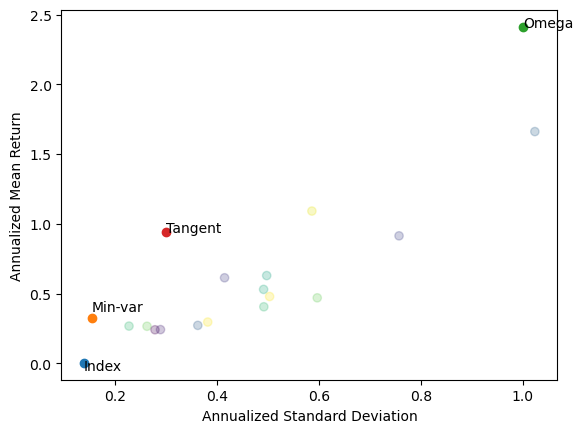

In [74]:
## - Scatter plot of risk-return representation of all stocks, including the index
## -  min-var portfolio, omega portfolio, and tangent portfolio

fig, ax = plt.subplots()

# Assign a random color to each stock
np.random.seed(12345)
colors = np.random.rand(len(mean_ret_stocks))

# Stocks
plt.scatter(sigma_ret_stocks, mean_ret_stocks, c = colors, alpha = 0.25)

# Index
plt.scatter(sigma_ret_index, mean_ret_index)
plt.annotate('Index', (sigma_ret_index, mean_ret_index - 0.05))

# Minimum-variance portfolio
plt.scatter(sigma_minvar, mean_minvar)
plt.annotate('Min-var', (sigma_minvar, mean_minvar + 0.05))

# Omega
plt.scatter(sigma_omega, mean_omega)
plt.annotate('Omega', (sigma_omega, mean_omega))

# Tangent
plt.scatter(sigma_tangent, mean_tangent)
plt.annotate('Tangent', (sigma_tangent, mean_tangent))

# Edit axis labels
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')

In [75]:
## - Compute coordinates of points on frontier, CML, and asymptote

# # Define the range for frontier plots
# range_mean_high = np.max(mean_ret_stocks) + 0.5
# range_mean_low = np.min(mean_ret_stocks) - 0.5

# Define range for frontier plots (MANUAL)
range_mean_high = 1
range_mean_low = -0.5

# Define array of mean returns for frontier plot
mean_plot = np.linspace(range_mean_low, range_mean_high, 500)

# Storage for points (\sigma) on the frontier, the asymptote, and the CML
sigma_F = []
sigma_asy = []
sigma_CML = []

# Compute \sigma for each of the three at each point
for i in range(len(mean_plot)):
    sigma_F_val = np.sqrt(sigma_minvar ** 2 + ((mean_plot[i] - mean_minvar) / mean_omega) ** 2)
    sigma_asy_val = (mean_plot[i] - mv_b / mv_a) / mean_omega
    sigma_CML_val = sigma_tangent * (mean_plot[i] - r0) / (mean_tangent - r0)
    sigma_F = np.append(sigma_F, sigma_F_val)
    sigma_asy = np.append(sigma_asy, sigma_asy_val)
    sigma_CML = np.append(sigma_CML, sigma_CML_val)

## Q7

Text(0, 0.5, 'Annualized Mean Return')

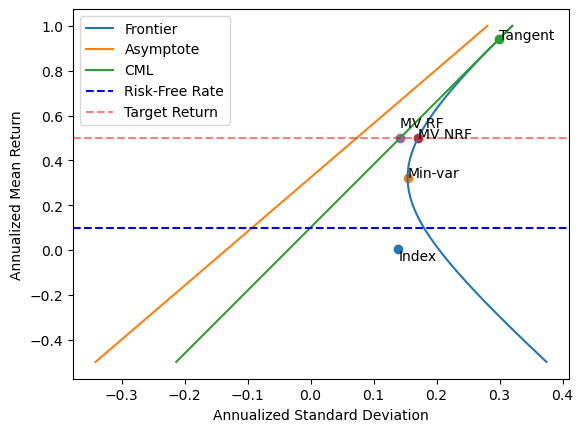

In [76]:
## - Plot frontier, CML, and asymptote
fig, ax = plt.subplots()

# MV-efficient frontier, CML, and asymptote
plt.plot(sigma_F, mean_plot, alpha = 1)
plt.plot(sigma_asy, mean_plot, alpha = 1)
plt.plot(sigma_CML, mean_plot, alpha = 1)

# Risk-free rate
plt.axhline(y = r0, color = 'b', linestyle = '--')

# Horizontal line at a target (annualized) expected return
plt.axhline(y = target_ret, color = 'r', linestyle = '--', alpha = 0.5) 

plt.legend(['Frontier', 'Asymptote', 'CML', 'Risk-Free Rate', 'Target Return'], loc = 2)

# Index
plt.scatter(sigma_ret_index, mean_ret_index)
plt.annotate('Index', (sigma_ret_index, mean_ret_index - 0.05))

# Minimum-variance portfolio
plt.scatter(sigma_minvar, mean_minvar)
plt.annotate('Min-var', (sigma_minvar, mean_minvar))

# # Omega
# plt.scatter(sigma_omega, mean_omega)
# plt.annotate('Omega', (sigma_omega, mean_omega))

# Tangent
plt.scatter(sigma_tangent, mean_tangent)
plt.annotate('Tangent', (sigma_tangent, mean_tangent))

# Mean-variance efficient with no risk-free asset
plt.scatter(sigma_mv_nrf, mean_mv_nrf)
plt.annotate('MV NRF', (sigma_mv_nrf, mean_mv_nrf))

# Mean-variance efficient with risk-free asset
plt.scatter(sigma_mv_rf, mean_mv_rf)
plt.annotate('MV RF', (sigma_mv_rf, mean_mv_rf + 0.05))

# Edit axis labels
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')

# Tracking Error Variance Analysis

## Q1

In [77]:
## - Stock betas w.r.t. index

# Compute the excess returns of the benchmark [ANNUALIZED]
exc_ret_benchmark = (ann_factor * ret_index - r0).array

# Storage for estimated betas and R-squared
stock_betas = []
stock_rsq = []

# Iterate beta estimation over each stock
for i in mean_ret_stocks.index:
    exc_ret_stock = (ann_factor * ret_stocks[i] - r0).array.reshape(-1, 1) # [ANNUALIZED RETURNS]
    reg = LinearRegression(fit_intercept = False).fit(exc_ret_benchmark.reshape(-1, 1), exc_ret_stock)
    beta = reg.coef_[0]
    rsq = reg.score(exc_ret_benchmark.reshape(-1, 1), exc_ret_stock)
    stock_betas = np.append(stock_betas, beta)
    stock_rsq = np.append(stock_rsq, rsq)

# Reshape stock_betas
stock_betas = stock_betas.reshape((len(mean_ret_stocks), -1))

stock_betas_df = pd.DataFrame(data = stock_betas, index = SR_stocks_sorted.head(n_stocks).index)
stock_betas_df

,0
NEU.AX,0.789373
AZS.AX,1.461206
EMR.AX,0.558857
SMR.AX,0.761799
WHC.AX,1.038410
NHC.AX,0.897809
BGL.AX,1.302141
SVW.AX,0.944316
WOR.AX,1.128063
YAL.AX,0.708122


Text(0, 0.5, 'Annualized Excess Expected Return')

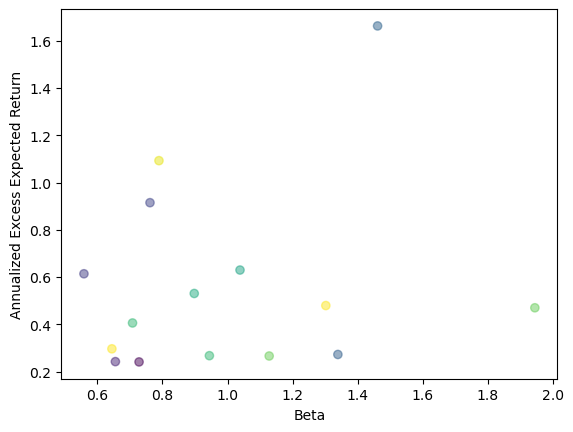

In [78]:
## - Plot stocks on beta-return space -- NOT PERFECTLY COLLINEAR SINCE INDEX IS NOT MV-EFFICIENT
plt.scatter(stock_betas, mean_ret_stocks, c = colors, alpha = 0.5)

plt.xlabel('Beta')
plt.ylabel('Annualized Excess Expected Return')

## Q2

In [79]:
## - Compute auxiliary quantities for the construction of the TEV-optimal portfolio

# Load null_space function from scipy.linalg
from scipy.linalg import null_space

# Define the matrix B
B_mat = np.array([mean_ret_stocks, vec1]).T

# Compute B_\perp
B_perp = null_space(B_mat.T)

# Compute inverse term in the matrix Q
inv_mat_term = np.linalg.inv(B_perp.T @ cov_ret_stocks.to_numpy() @ B_perp)

# Compute the matrix Q
Q_mat = B_perp @ inv_mat_term @ B_perp.T

# Compute right-inverse of B^\top (from definition)
BT_rinv = B_mat @ np.linalg.inv(B_mat.T @ B_mat)

# Compute the matrix C
C_mat = (np.identity(len(mean_ret_stocks)) - Q_mat @ cov_ret_stocks.to_numpy()) @ BT_rinv

In [80]:
## - Construct the TEV-optimal portfolio and calculate characteristics

# TEV-optimal portfolio
phi_tev = var_ret_index * Q_mat @ stock_betas + C_mat @ np.array([[target_ret], [1]])

# Determine the mean and standard deviation of the porfolio return of the TEV-optimal portfolio
sigma_tev = np.sqrt(phi_tev.T @ cov_ret_stocks.to_numpy() @ phi_tev)
mean_tev = phi_tev.T @ mean_ret_stocks   # should be equal to target mean

# Determine the TEV achieved by the TEV-optimal portfolio
min_tev = sigma_tev ** 2 + var_ret_index - 2 * var_ret_index * phi_tev.T @ stock_betas

In [81]:
phi_tev_df = pd.DataFrame(data = phi_tev, index = SR_stocks_sorted.head(n_stocks).index)

print('Composition of TEV portfolio: ')
print(phi_tev_df)

print('Mean return of TEV portfolio: ', mean_tev)
print('Standard deviation of return of MF RF portfolio: ', sigma_tev)

print('Minimum TEV: ', min_tev)

Composition of TEV portfolio: 
               0
NEU.AX  0.093665
AZS.AX  0.048520
EMR.AX  0.125118
SMR.AX  0.036595
WHC.AX  0.041129
NHC.AX  0.009339
BGL.AX  0.029135
SVW.AX  0.188808
WOR.AX  0.115387
YAL.AX -0.000967
BOE.AX -0.007364
ORG.AX  0.055652
VNT.AX  0.045010
AGL.AX  0.100341
PME.AX  0.119632
Mean return of TEV portfolio:  [0.5]
Standard deviation of return of MF RF portfolio:  [[0.18097125]]
Minimum TEV:  [[0.01653626]]


## Q3

In [82]:
# Beta of TEV
beta_tev = phi_tev.T @ stock_betas

beta_tev

array([[0.91975588]])

In [83]:
# Beta of MV with no RF
beta_mv_nrf = phi_mv_nrf.T @ stock_betas

beta_mv_nrf

array([0.729779])

In [84]:
# Beta of MV with RF
beta_mv_rf = sep_thm_coef * phi_tangent.T @ stock_betas

beta_mv_rf

array([0.34172978])

## Q4

In [85]:
## - Construct the TEV efficient frontier using the MV frontier

# Calculate the sigma-coordinates of the TEV frontier
sigma_TEVfront = np.sqrt(sigma_F ** 2 + (var_ret_index ** 2) * stock_betas.T @ Q_mat @ stock_betas)
sigma_TEVfront = sigma_TEVfront.T

Text(0, 0.5, 'Annualized Mean Return')

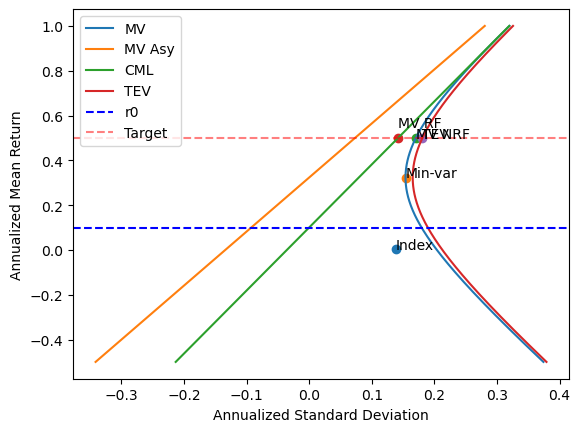

In [86]:
## - Plot MV frontier, TEV frontier, CML, and asymptote
fig, ax = plt.subplots()

# MV-efficient frontier, CML, and asymptote
plt.plot(sigma_F, mean_plot, alpha = 1)
plt.plot(sigma_asy, mean_plot, alpha = 1)
plt.plot(sigma_CML, mean_plot, alpha = 1)
plt.plot(sigma_TEVfront, mean_plot, alpha = 1)

# Risk-free rate
plt.axhline(y = r0, color = 'b', linestyle = '--')

# Horizontal line at a target (annualized) expected return
plt.axhline(y = target_ret, color = 'r', linestyle = '--', alpha = 0.5) 

plt.legend(['MV', 'MV Asy', 'CML', 'TEV', 'r0', 'Target'], loc = 2)

# # Stocks
# plt.scatter(sigma_ret_stocks, mean_ret_stocks, c = colors, alpha = 0.25)

# Index
plt.scatter(sigma_ret_index, mean_ret_index)
plt.annotate('Index', (sigma_ret_index, mean_ret_index))

# Minimum-variance portfolio
plt.scatter(sigma_minvar, mean_minvar)
plt.annotate('Min-var', (sigma_minvar, mean_minvar))

# # Omega
# plt.scatter(sigma_omega, mean_omega)
# |plt.annotate('Omega', (sigma_omega, mean_omega))

# # Tangent
# plt.scatter(sigma_tangent, mean_tangent)
# plt.annotate('Tangent', (sigma_tangent, mean_tangent))

# Mean-variance efficient with no risk-free asset
plt.scatter(sigma_mv_nrf, mean_mv_nrf)
plt.annotate('MV NRF', (sigma_mv_nrf, mean_mv_nrf))

# Mean-variance efficient with risk-free asset
plt.scatter(sigma_mv_rf, mean_mv_rf)
plt.annotate('MV RF', (sigma_mv_rf, mean_mv_rf + 0.05))

# TEV efficient
plt.scatter(sigma_tev, mean_tev)
plt.annotate('TEV', (sigma_tev, mean_tev))

# Edit axis labels
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')

**Note:** Since we are only taking a subset of the constituent stocks of the ASX 200, it is possible that the index will not fall on the TEV frontier. It can be shown that as we increase the size of the subset of stocks we take (compare e.g. the present case $d = 30$ with $d = 125$ risky assets), the resulting TEV frontier will approach the index.

In the analysis of Jorion (2003) and Roll (1992), the benchmark will naturally appear on the TEV frontier as their construction of TEV-optimal portfolios are based on (optimal) deviations from the benchmark composition (i.e. the benchmark constituents and the risky asset choice set coincide). This means that the benchmark will be TEV-optimal when the investor chooses $g = 0$ (no gain over the benchmark).

# Part 2: PCA and Factor Model Approach

**Note:** PCA to be performed on the (centered) returns time series for the top stocks only, not the full list of constituent stocks.

## Q1

In [87]:
## - Construct centered returns time series

# Centered returns
c_ret_stocks = ret_stocks - ret_stocks.mean(axis = 0)

# Covariance matrix of centered returns
cov_c_ret_stocks = c_ret_stocks.cov()

## Q2

In [88]:
## - SVD of the covariance matrix of the centered data set

# SVD using np.linalg.svd
U, D2, V = np.linalg.svd(cov_c_ret_stocks)

# Determine total variance/inertia of sample
inertia = sum(D2)

# Determine cumulative variance measured by first k principal components
cumulative_var = np.cumsum(D2 / inertia)

print('Inertia of sample: ', inertia)
print('Cumulative variance explained by each PC:')
print(cumulative_var)

Inertia of sample:  0.015888503673649884
Cumulative variance explained by each PC:
[0.28367841 0.48951605 0.59632509 0.67714146 0.75215011 0.80734989
 0.84629098 0.87771771 0.90721277 0.93496271 0.95324352 0.96946228
 0.98226435 0.99308279 1.        ]


## Q3

In [89]:
## - PCA with 5 principal components

# PCA with sklearn.decomposition.PCA
pca = PCA(n_components = 5)
pca_comps = pca.fit(c_ret_stocks).components_
pca_factors = pca.fit_transform(c_ret_stocks)

# # Should be the same as the kth entry in cumulative_var above
# sum(pca.explained_variance_ratio_)

# Covariance of PCs
pca_cov = np.cov(pca_factors, rowvar = False)     # Observe that it is approximately diagonal (as expected)
pca_cov_inv = np.linalg.inv(pca_cov)

In [90]:
# np.diag(pca_cov)

In [91]:
# # Eigenvalues and eigenvectors of covariance matrix of centered returns
# eigenvalues, eigenvectors = np.linalg.eig(cov_c_ret_stocks)
# eigenvalues

In [92]:
## - Coefficients of k-factor model with PCA factors

# B matrix
kfm_B = pca_comps.T

# A vector
kfm_A = ret_stocks.mean(axis = 0)

In [93]:
kfm_A

NEU.AX    0.004301
AZS.AX    0.006543
EMR.AX    0.002418
SMR.AX    0.003601
WHC.AX    0.002480
NHC.AX    0.002090
BGL.AX    0.001889
SVW.AX    0.001054
WOR.AX    0.001049
YAL.AX    0.001599
BOE.AX    0.001852
ORG.AX    0.001168
VNT.AX    0.000950
AGL.AX    0.000955
PME.AX    0.001074
dtype: float64

In [94]:
kfm_B

array([[ 7.62800738e-02,  5.48912103e-02, -5.49022650e-01,
         3.54014185e-01,  7.06689043e-01],
       [ 8.56242436e-01, -4.88451122e-01,  1.43522194e-01,
         3.63251129e-04,  3.64455490e-02],
       [ 1.55949944e-02,  6.25008737e-02, -1.44518469e-01,
         6.61043812e-02, -2.83093399e-01],
       [ 2.61503977e-01,  5.84593058e-01,  4.63455582e-01,
         5.90510336e-01,  3.96874299e-02],
       [ 1.93527070e-01,  3.43783893e-01, -1.31733744e-02,
        -4.05220894e-01,  1.23763772e-01],
       [ 1.85032126e-01,  3.46421510e-01,  2.56517131e-02,
        -3.92950011e-01,  1.30730333e-01],
       [ 1.09686526e-01,  1.11917308e-01, -2.53515911e-01,
         2.49463427e-01, -5.18591056e-01],
       [ 5.74631223e-02,  4.09135091e-02, -1.32872137e-01,
         6.02438085e-03, -4.56147549e-02],
       [ 9.26875671e-02,  8.67613287e-02, -1.17224906e-01,
        -4.58767815e-02, -6.86100781e-02],
       [ 1.53096069e-01,  3.14672937e-01, -3.82872312e-03,
        -3.68453748e-01

In [95]:
# Covariance matrix of factors
np.diag(pca_cov)

array([0.00450723, 0.00327045, 0.00169704, 0.00128405, 0.00119178])

In [96]:
# Eigenvalues and eigenvectors of covariance matrix of centered returns
eigenvalues, eigenvectors = np.linalg.eig(cov_c_ret_stocks)
eigenvalues[0:5]

array([0.00450723, 0.00327045, 0.00169704, 0.00128405, 0.00119178])

## Q4

In [97]:
# Beta of each risky asset w.r.t. F1
kfm_B[:,0]

array([0.07628007, 0.85624244, 0.01559499, 0.26150398, 0.19352707,
       0.18503213, 0.10968653, 0.05746312, 0.09268757, 0.15309607,
       0.24406593, 0.03405384, 0.07212701, 0.05250509, 0.06829075])

## Q5

In [98]:
## - Approximate the risk premium

# Estimation via linear regression
reg = LinearRegression(fit_intercept=True).fit(kfm_B, kfm_A)
apt_lambda = reg.coef_
apt_lambda0 = reg.intercept_

# Determine if minimum is 0
vec1 = np.linspace(1, 1, len(kfm_A))
obj_func_value = sum((kfm_A - apt_lambda0 * vec1 - kfm_B @ apt_lambda) ** 2)
print(obj_func_value)

4.7109198511272745e-06


In [99]:
apt_lambda, apt_lambda0

(array([ 0.00630123,  0.00023869, -0.0005242 ,  0.00177612,  0.00191792]),
 0.001120106811602409)

## Q6

In [100]:
# Calculated estimated returns from exact factor model \hat{R} = A + BF
est_ret_stocks = (kfm_A.to_numpy().reshape((-1,1)) + kfm_B @ pca_factors.T).T

# Calculate exact factor model residuals R - \hat{R}
kfm_residuals = ret_stocks.reset_index(drop = True) - est_ret_stocks
# kfm_residuals.mean(axis = 0)    # Should be approximately zero

# Compare the empirical covariance matrix and the covariance matrix from the k-factor model [ANNUALIZED]
kfm_ret_cov = ann_factor * (kfm_B @ pca_cov @ kfm_B.T + kfm_residuals.cov())
np.sum(np.sum((cov_ret_stocks - kfm_ret_cov) ** 2))    # Should be approximately zero

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


3.813671252620371e-29

# Alternative Portfolio Optimization Criteria

## Maximum Sharpe Ratio Portfolio

The MSRP optimization problem is given by

$$\max_{\phi \in \mathbb{R}^d} \frac{\phi^\top M - r_0}{\sqrt{\phi^\top \Sigma \phi}} \qquad \text{subject to} \quad \phi^\top \mathbf{1}_d = 1 \quad \text{and} \quad \phi \geq 0.$$

The codes below solve the MRSP optimization problem using ``scipy.optimize``

In [101]:
from scipy.optimize import minimize

# Convert mean vector and covariance matrix to numpy arrays (for convenience)
M = mean_ret_stocks.to_numpy()
Sigma = cov_ret_stocks.to_numpy()

# Function to minimize - negative portfolio sharpe ratio
def neg_port_SR(phi):
    return - (phi.T @ M - r0) / np.sqrt(phi.T @ Sigma @ phi)

# Constraints - investment portfolio constraint
def cons_inv_port(phi):
    return np.sum(phi) - 1

# Constraint dictionary
cons = [{'type' : 'eq', 'fun' : cons_inv_port}]

# Optimization
phi_init = np.ones(len(M)) / len(M)

msrp_out = minimize(neg_port_SR, phi_init, method = 'SLSQP',
                    bounds = [(0, None) for _ in range(len(M))], # for phi >= 0
                    constraints = cons)

# MRSP portfolio composition
msrp_comp = msrp_out.x
mean_msrp = msrp_comp.T @ M
sigma_msrp = np.sqrt(msrp_comp.T @ Sigma @ msrp_comp)

print('Composition of the MSR portfolio:')
print(np.round(msrp_comp, 4))

print(' ')

print('Mean return of MSR portfolio:', np.round(mean_msrp, 4))
print('Std dev of return of MSR portfolio:', np.round(sigma_msrp, 4))

#

Composition of the MSR portfolio:
[0.2679 0.1371 0.2924 0.0989 0.0781 0.     0.     0.     0.     0.
 0.     0.0674 0.     0.0581 0.    ]
 
Mean return of MSR portfolio: 0.874
Std dev of return of MSR portfolio: 0.28


## Mean-Variance with Box Constraints

Here, we will use ``scipy.optimize`` to solve the mean-variance portfolio optimization problem with constraints (similar to what is illustrated in ``Mean-Variance Analysis (EURO STOXX 50).ipynb`` in class). In particular, we will solve the optimization problem: Given a target expected return $\bar{m}$, $\min_{\phi \in \mathbb{R}^d} \phi^\top \Sigma \phi$ subject to the constraints:
- Target mean return: $\phi^\top M = \bar{m}$
- Investment portfolio: $\phi^\top \mathbf{1}_d = 1$
- Market neutral: $\phi^\top \boldsymbol{\beta}_{\text{ASX}} = 0$, where $\boldsymbol{\beta}_{\text{ASX}}$ is the vector of stock betas with respect to the ASX 200 index
- Leverage constraint: $\|\phi\|_\infty := \max_i |\phi_i| \leq 0.20$



In [102]:
# Objective function
def port_var(phi):
    return phi.T @ Sigma @ phi

# Equality constraint - target mean return
def cons_target_ret(phi):
    return (phi.T @ M - target_ret)

# Equality constraint - investment portfolio
def cons_inv_port(phi):
    return (np.sum(phi) - 1)

# Equality constraint - market neutral
def cons_mkt_neutral(phi):
    return phi.T @ stock_betas

# Inequality constraint - maximum weight
def cons_max_weight(phi):
    return 0.50 - np.max(np.abs(phi))

# Constraint dictionary
cons = ({'type' : 'eq', 'fun' : cons_inv_port},
        {'type' : 'eq', 'fun' : cons_target_ret},
        {'type' : 'eq', 'fun' : cons_mkt_neutral},
        {'type' : 'ineq', 'fun' : cons_max_weight})

# # Bounds on decision variables (componentwise constraints)
# bnds = [(0, 0.20) for _ in range(len(M))]

# Optimization
phi_init = np.ones(len(M)) / len(M)
mv_cons_out = minimize(port_var, phi_init, constraints = cons)

# Constrained mean-variance optimal portfolio composition
mv_cons_comp = mv_cons_out.x
mean_mv_cons = mv_cons_comp.T @ M
sigma_mv_cons = np.sqrt(mv_cons_comp.T @ Sigma @ mv_cons_comp)

print('Composition of the constrained MV portfolio:')
print(np.round(mv_cons_comp, 4))

print(' ')

print('Mean return of constrained MV portfolio:', np.round(mean_mv_cons, 4))
print('Std dev of return of constrained MV portfolio:', np.round(sigma_mv_cons, 4))


Composition of the constrained MV portfolio:
[ 0.1645  0.0264  0.3626  0.0728 -0.1703  0.1214 -0.1744  0.3622 -0.369
  0.145  -0.2572  0.1914  0.3572  0.3915 -0.2243]
 
Mean return of constrained MV portfolio: 0.5
Std dev of return of constrained MV portfolio: 0.2885


## Kelly Portfolio: Mean-Variance Approximation

In [103]:
# Objective function
def neg_kelly_mv(phi):
    value = phi.T @ M - 0.5 * (phi.T @ M) ** 2 - 0.5 * (phi.T @ Sigma @ phi) / (1 + 2 * phi.T @ M)
    return -value

# Equality constraint - investment portfolio
def cons_inv_port(phi):
    return (np.sum(phi) - 1)

# Inequality constraint - maximum weight

# Constraint dictionary
cons = ({'type' : 'eq', 'fun' : cons_inv_port})

# Bounds on decision variables (componentwise constraints)
bnds = [(0, None) for _ in range(len(M))]

# Optimization
phi_init = np.ones(len(M)) / len(M)
kelly_out = minimize(neg_kelly_mv, phi_init,
                       bounds = bnds, constraints = cons)

# Kelly portfolio composition
kelly_comp = kelly_out.x
mean_kelly = kelly_comp.T @ M
sigma_kelly = np.sqrt(kelly_comp.T @ Sigma @ kelly_comp) 

print('Composition of the Kelly portfolio:')
print(np.round(kelly_comp, 4))

print(' ')

print('Mean return of Kelly portfolio:', np.round(mean_kelly, 4))
print('Std dev of return of Kelly portfolio:', np.round(sigma_kelly, 4))


Composition of the Kelly portfolio:
[0.3102 0.1681 0.3013 0.1179 0.0763 0.     0.     0.     0.     0.
 0.     0.0262 0.     0.     0.    ]
 
Mean return of Kelly portfolio: 0.967
Std dev of return of Kelly portfolio: 0.3156


## Expected Exponential Utility: Mean-Variance Approximation

For the utility function $U(x) = 1 - e^{-\lambda x}$ where $\lambda > 0$, we have $U'(x) = \lambda e^{- \lambda x}$ and $U''(x) = - \lambda^2 e^{- \lambda x}$.

In [104]:
# Objective function
risk_par = 10
def neg_exp_eu_mv(phi):
    value = 1 - np.exp(- risk_par * phi.T @ M) - 0.5 * (risk_par ** 2) * np.exp(- risk_par * phi.T @ M) * phi.T @ Sigma @ phi
    return -value

# Equality constraint - investment portfolio
def cons_inv_port(phi):
    return (np.sum(phi) - 1)

# Inequality constraint - maximum weight

# Constraint dictionary
cons = ({'type' : 'eq', 'fun' : cons_inv_port})

# Bounds on decision variables (componentwise constraints)
bnds = [(0, None) for _ in range(len(M))]

# Optimization
phi_init = np.ones(len(M)) / len(M)
eu_out = minimize(neg_exp_eu_mv, phi_init,
                       bounds = bnds, constraints = cons)

# Kelly portfolio composition
eu_comp = eu_out.x
mean_eu = eu_comp.T @ M
sigma_eu = np.sqrt(eu_comp.T @ Sigma @ eu_comp) 

print('Composition of the expected utility portfolio:')
print(np.round(eu_comp, 4))

print(' ')

print('Mean return of expected utility portfolio:', np.round(mean_eu, 4))
print('Std dev of return of expected utility portfolio:', np.round(sigma_eu, 4))


Composition of the expected utility portfolio:
[0.282  0.4314 0.0828 0.1593 0.0445 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.    ]
 
Mean return of expected utility portfolio: 1.2497
Std dev of return of expected utility portfolio: 0.507


Text(0, 0.5, 'Annualized Mean Return')

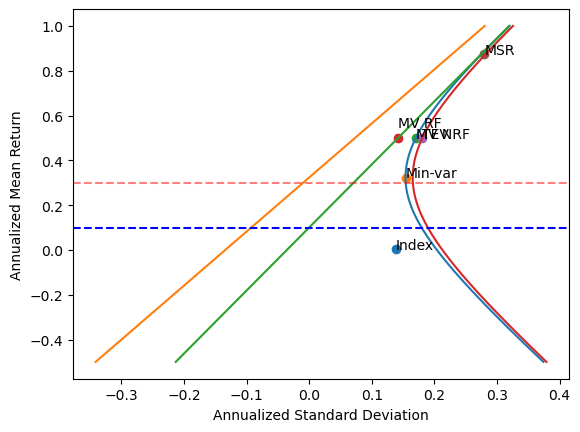

In [105]:
## - Plot MV frontier, TEV frontier, CML, and asymptote
fig, ax = plt.subplots()

# MV-efficient frontier, CML, and asymptote
plt.plot(sigma_F, mean_plot, alpha = 1)
plt.plot(sigma_asy, mean_plot, alpha = 1)
plt.plot(sigma_CML, mean_plot, alpha = 1)
plt.plot(sigma_TEVfront, mean_plot, alpha = 1)

# Risk-free rate
plt.axhline(y = r0, color = 'b', linestyle = '--')

# Horizontal line at a target (annualized) expected return
plt.axhline(y = 0.30, color = 'r', linestyle = '--', alpha = 0.5) 

# plt.legend(['MV', 'MV Asy', 'CML', 'TEV', 'MSR', 'r0', 'Target'], loc = 2)

# # Stocks
# plt.scatter(sigma_ret_stocks, mean_ret_stocks, c = colors, alpha = 0.25)

# Index
plt.scatter(sigma_ret_index, mean_ret_index)
plt.annotate('Index', (sigma_ret_index, mean_ret_index))

# Minimum-variance portfolio
plt.scatter(sigma_minvar, mean_minvar)
plt.annotate('Min-var', (sigma_minvar, mean_minvar))

# # Omega
# plt.scatter(sigma_omega, mean_omega)
# |plt.annotate('Omega', (sigma_omega, mean_omega))

# # Tangent
# plt.scatter(sigma_tangent, mean_tangent)
# plt.annotate('Tangent', (sigma_tangent, mean_tangent))

# Mean-variance efficient with no risk-free asset
plt.scatter(sigma_mv_nrf, mean_mv_nrf)
plt.annotate('MV NRF', (sigma_mv_nrf, mean_mv_nrf))

# Mean-variance efficient with risk-free asset
plt.scatter(sigma_mv_rf, mean_mv_rf)
plt.annotate('MV RF', (sigma_mv_rf, mean_mv_rf + 0.05))

# TEV efficient
plt.scatter(sigma_tev, mean_tev)
plt.annotate('TEV', (sigma_tev, mean_tev))

# Maximum Sharpe ratio
plt.scatter(sigma_msrp, mean_msrp)
plt.annotate('MSR', (sigma_msrp, mean_msrp))

# Edit axis labels
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')

## (IGNORE THIS SECTION) Solution using ``cvxpy``

**Does not work for $r_0 \neq 0$...**

This problem can be solved using the Dinkelbach method. First, the MRSP optimization problem is approximated as a sequence of convex optimization problems given by

$$\max_{\phi \in \mathbb{R}^d} \left\{\phi^\top M - r_0 - y^k \sqrt{\phi^\top \Sigma \phi} \right\} \qquad \text{subject to} \quad \phi^\top \mathbf{1}_d = 1 \quad \text{and} \quad \phi \geq 0,$$

where $k \in \mathbb{N}$ is the iteration index and the parameter $y^k$ is sequentially defined as

$$y^k = \frac{(\phi^k)^\top M - r_0}{\sqrt{(\phi^k)^\top \Sigma \phi^k}}.$$

The implementation of the Dinkelbach method using ``cvxpy`` is shown below.

In [106]:
# # %pip install cvxpy
# import cvxpy as cp

In [107]:
# # Convert mean vector and covariance matrix to numpy arrays (for convenience)
# M = mean_ret_stocks.to_numpy()
# vec_ones = np.ones(len(M))
# Sigma = cov_ret_stocks.to_numpy()
# Sigma12 = np.linalg.cholesky(Sigma)

# # Dinkelbach formulation as a cvxpy problem with parameter input
# def mosr_dinkelbach(y):
#     phi = cp.Variable(Sigma.shape[0])
#     prob = cp.Problem(
#         cp.Maximize(phi.T @ (M - r0 * vec_ones) - y * cp.norm(Sigma12 @ phi, 2)),
#         constraints = [cp.sum(phi) == 1, phi >= 0]
#     )
#     prob.solve()
#     return phi.value

# # Initial portfolio weights (must satisfy phi.T @ M - r0 >= 0)
# i_max = np.argmax(M)
# phi_k = np.zeros(len(M))
# phi_k[i_max] = 1

# phi_k.T @ M - r0

It is recommended that, when writing a ``cvxpy`` program, only ``cvxpy`` functions are used. In the code above, ``cp.norm(x, 2)`` denotes the Euclidean norm $\|x\|_2 := \sqrt{x^\top x}$ for $x \in \mathbb{R}^d$.

In [108]:
# # While-loop for the Dinkelbach method
# k = 1   # Iteration counter
# while k == 1 or np.max(np.abs(phi_k - phi_prev)) > 1e-6:
#     phi_prev = phi_k
#     y_k = (phi_k.T @ (M - r0 * vec_ones)) / np.sqrt(phi_k.T @ Sigma @ phi_k)
#     phi_k = mosr_dinkelbach(y_k)
#     k += 1

# phi_Dinkelbach = phi_k
# print(f'Number of iterations: {k - 1}')